In [1]:
%matplotlib notebook
import pandas as pd
from graph_tool import load_graph
from glob import glob
import pickle as pkl
from evaluate import evaluate_performance

In [2]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format('grid'))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
pos = graphviz_layout(gnx, root=0)


In [3]:
dataset = 'grid-64'
g = load_graph('data/{}/graph.gt'.format(dataset))
rows = []
for p in glob('outputs/paper_experiment/{}/si/mst/qs/0.1/*.pkl'.format(dataset)):
    infection_times, source, obs_nodes, true_edges, pred_edges = pkl.load(open(p, 'rb'))
    scores = evaluate_performance(g, None, source, pred_edges, obs_nodes,
                                  infection_times, true_edges,
                                  convert_to_directed=False)
    if scores[5] < 0.7:
        print(scores[5])
        break
    rows.append(scores)
df = pd.DataFrame(rows, columns=['n.prec', 'n.rec',
                                 'obj',
                                 'e.prec', 'e.rec',
                                 'rank-corr',
                                 'order accuracy'])    

0.642857142857


/home/cloud-user/code/source_finding/infer_time.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pred[root] = root
/home/cloud-user/code/source_finding/infer_time.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pred[root] = root


In [13]:
p = 'outputs/paper_experiment/barabasi-64/si/no-order/qs/0.9/20.pkl'
infection_times, source, obs_nodes, true_edges, pred_edges = pkl.load(open(p, 'rb'))
pred_edges

[(0, 28),
 (0, 52),
 (0, 31),
 (2, 6),
 (2, 17),
 (2, 54),
 (3, 8),
 (4, 7),
 (4, 44),
 (4, 54),
 (4, 21),
 (5, 54),
 (5, 8),
 (5, 53),
 (8, 23),
 (8, 14),
 (8, 20),
 (8, 11),
 (10, 53),
 (17, 58),
 (18, 31),
 (18, 32),
 (18, 33),
 (20, 55),
 (20, 47),
 (21, 45),
 (21, 25),
 (23, 31),
 (24, 52),
 (34, 54),
 (43, 53),
 (47, 49),
 (47, 56)]

In [5]:
infection_times

array([ 0.33416183,  0.16356338, -1.        , -1.        ,  0.15054884,
        0.3109618 ,  0.14769453, -1.        , -1.        ,  0.35477181,
       -1.        ,  0.21365448, -1.        ,  0.33283876, -1.        ,
       -1.        ,  0.12443903, -1.        ,  0.37110597, -1.        ,
        0.32173527,  0.16280172, -1.        , -1.        ,  0.31104206,
       -1.        , -1.        , -1.        ,  0.13443724,  0.28740304,
        0.21110403, -1.        , -1.        , -1.        ,  0.14500987,
       -1.        ,  0.34777562, -1.        , -1.        ,  0.32535153,
       -1.        , -1.        ,  0.1777091 ,  0.23229631,  0.22116352,
       -1.        ,  0.29413124,  0.28843768,  0.35407937,  0.        ,
        0.21785559, -1.        , -1.        ,  0.21031073, -1.        ,
       -1.        ,  0.32150252, -1.        ,  0.19412866,  0.34112899,
       -1.        , -1.        , -1.        ,  0.34552872])

In [7]:
from utils import edges2graph
true_tree = edges2graph(g, true_edges)
pred_tree = edges2graph(g, pred_edges)
root = next(v
            for v in pred_tree.vertices()
            if v.in_degree() == 0 and v.out_degree() > 0)

In [10]:
root, pred_edges

(58, [(6, 47), (6, 39), (8, 39), (8, 50), (39, 58)])

In [8]:
from graph_tool.topology import shortest_distance
from ic import get_infection_time
from utils import earliest_obs_node
"""
returns: predicted infection times on tree, t
for nodes in tree, time is not infinity
for nodes not in tree, time is infinity
"""
t = pred_tree
root = earliest_obs_node(obs_nodes, infection_times)
obs_nodes, infection_times
dist = get_infection_time(t, source=root)
dist

PropertyArray([ 0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

<IPython.core.display.Javascript object>


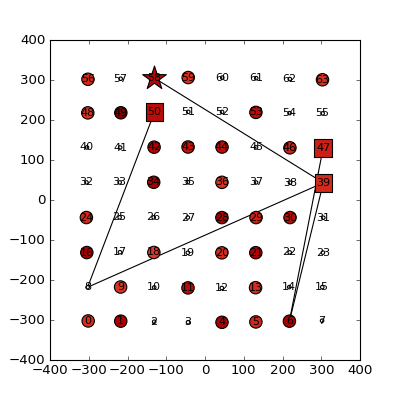

In [9]:
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=root, with_labels=True,
              ax=ax,
              edges=pred_edges)

In [ ]:
from graph_tool.search import bfs_search
from infer_time import TopDownVisitor, BottomUpVisitor
from gt_utils import bottom_up_traversal

td_vis = TopDownVisitor(np.ones(g.num_vertices(), dtype=np.int) * -1, root, obs_nodes)
bfs_search(t, source=root, visitor=td_vis)

bu_vis = BottomUpVisitor(np.ones(g.num_vertices(), dtype=np.int) * -1, root, obs_nodes)
bottom_up_traversal(t, vis=bu_vis)

In [ ]:
infection_times

In [ ]:
debug = False
hidden_nodes = set(map(int, t.vertices())) - set(obs_nodes)
pred_infection_time = np.array(infection_times)
dist = shortest_distance(t, source=root)
for v in hidden_nodes:
    ans, des = td_vis.pred[v], bu_vis.pred[v]

    if debug:
        print(v, ans, des)
        
    denum = dist[des] - dist[ans]
    numer = dist[v] - dist[ans]
    pred_infection_time[v] = infection_times[ans] + numer / denum * (infection_times[des] - infection_times[ans])
    
    if debug:
        assert pred_infection_time[v] > infection_times[ans]
        assert pred_infection_time[v] < infection_times[des]

        print('t(ans), t(des): {}, {}'.format(infection_times[ans], infection_times[des]))
        print('numer {}'.format(numer))
        print('denum {}'.format(denum))    
        print('pred time {}'.format(pred_infection_time[v]))

In [ ]:
print(hidden_nodes)
print(pred_infection_time[list(hidden_nodes)])
print(infection_times[list(hidden_nodes)])
np.all(pred_infection_time[obs_nodes] == infection_times[obs_nodes])

In [27]:
from graph_tool import Graph
print(len(pred_edges))
t = Graph(directed=True)
for _ in range(g.num_vertices()):
    t.add_vertex()
for u, v in pred_edges:
    u, v = int(u), int(v)
    t.add_edge(u, v)
    t.add_edge(v, u)
print(t.num_edges())    

33
66


In [29]:

pred_edges

(30,
 [(0, 28),
  (0, 52),
  (0, 31),
  (2, 6),
  (2, 17),
  (2, 54),
  (3, 8),
  (4, 7),
  (4, 44),
  (4, 54),
  (4, 21),
  (5, 54),
  (5, 8),
  (5, 53),
  (8, 23),
  (8, 14),
  (8, 20),
  (8, 11),
  (10, 53),
  (17, 58),
  (18, 31),
  (18, 32),
  (18, 33),
  (20, 55),
  (20, 47),
  (21, 45),
  (21, 25),
  (23, 31),
  (24, 52),
  (34, 54),
  (43, 53),
  (47, 49),
  (47, 56)])